In [1]:
%load_ext autoreload
import ais_predict.trajpred.posgp as pgp
import ais_predict.datasets.bigquery as bq
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
plt.rcParams["figure.figsize"] = (14, 10)

<AxesSubplot:>

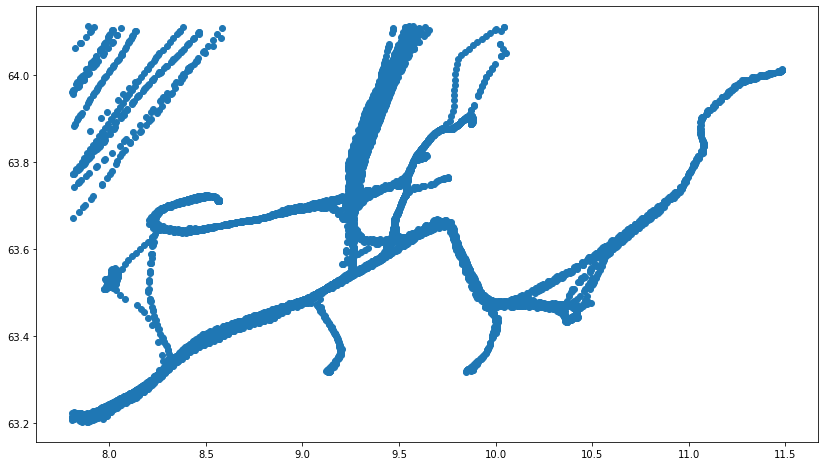

In [2]:
df = bq.download(limit=10000, lead=1)
df.position.plot()

<AxesSubplot:>

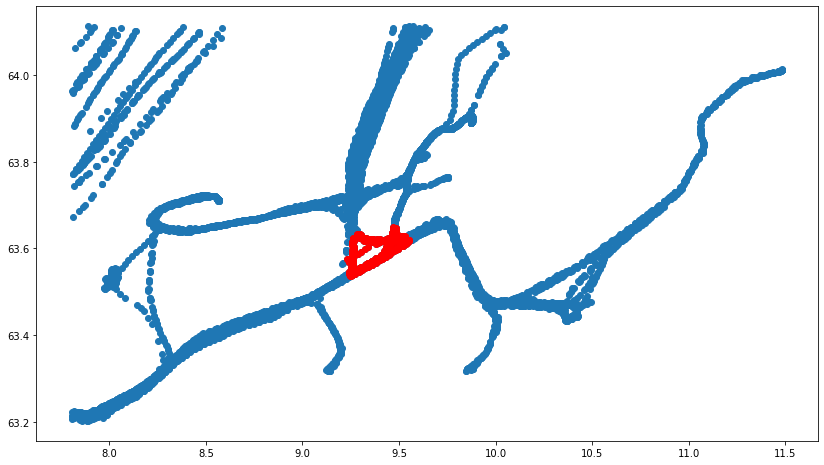

In [5]:
center = df.position.sample().to_crs(epsg=3857).to_numpy()[0]
subset = df.to_crs(epsg=3857).within(center.buffer(20e3))
ax = df.plot()
df[subset].plot(ax=ax, color="red")

In [6]:
within = gpd.GeoSeries(center.buffer(20e3, resolution=4), crs="epsg:3857").to_crs("wgs84").to_numpy()[0]
d = bq.download(lead=4, within=within, limit=1000)

<AxesSubplot:>

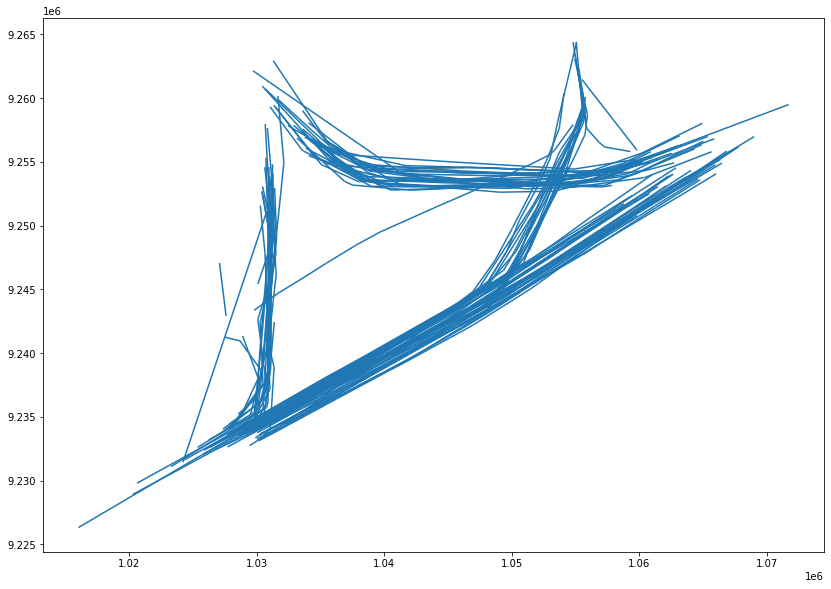

In [7]:
from shapely.geometry import Point, LineString
import geopandas as gpd

p = gpd.GeoSeries(d[["position", "position_1"]].apply(lambda x: LineString(x.tolist()), axis=1), crs="wgs84").to_crs(epsg=3857)
temp = gpd.GeoDataFrame({"lines": p, "cog": d.cog}, geometry="lines")
temp.plot()

In [61]:
train_msk = np.random.rand(len(d)) < 0.5 
train = d[train_msk]
test = d[~train_msk]
train_x, train_y = pgp.samples_from_lag_n_df(train, n=4)
test_x, test_y = pgp.samples_from_lag_n_df(test, n=4)

In [90]:
%autoreload
m = pgp.PosGP(train_x, train_y)
f, std = m(test_x)
np.mean(abs(f - test_y), axis=0)

[5572.78468423 1272.05822852 5130.37116271 ...  208.6720473   306.49742005
  792.67176405]


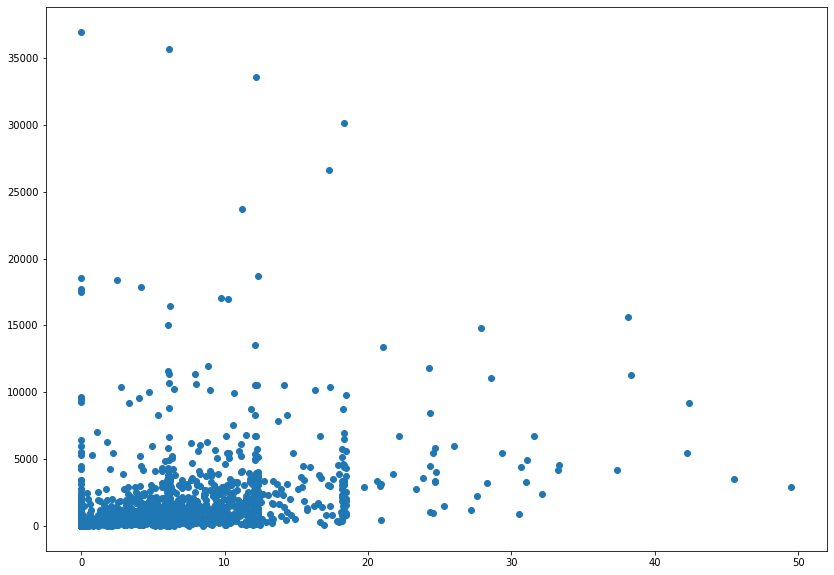

In [70]:
err = np.linalg.norm(f-test_y, axis=1)
print(err)
plt.scatter(test_x[:, -1] / 60, err)

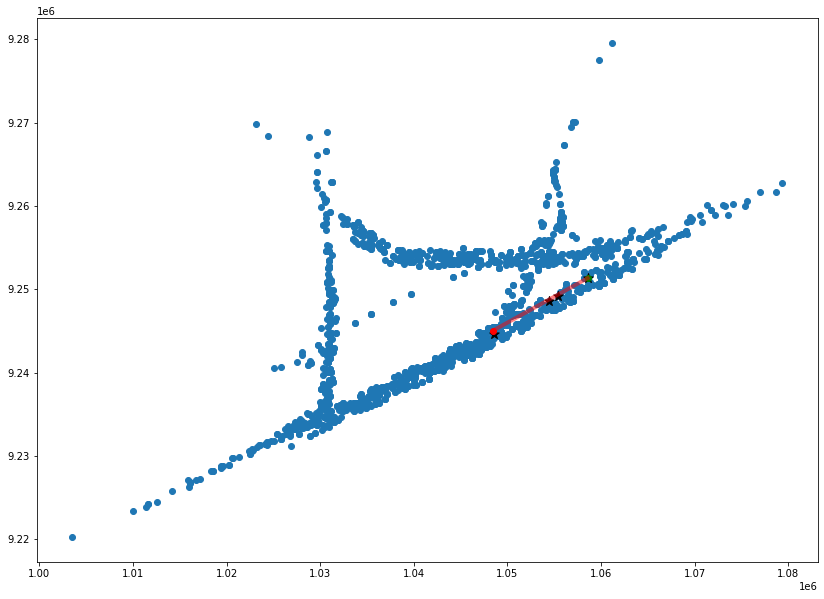

In [89]:
pX, pY = pgp.samples_from_lag_n_df(test.sample(), 4)

t = np.linspace(pX[0, -1], pX[-1, -1], 10)
X_pred = np.empty((len(t), pX.shape[-1]))
X_pred[:, -1] = t
X_pred[:, :-1] = pX[0, :-1]


pred, std = m(X_pred)
plt.scatter(*train_y.T)
plt.plot(*pred.T, color="red", alpha=0.5, linewidth=4)
plt.scatter(*pY.T, color="black", marker="*", s=100)
plt.scatter(*pred[0, :], color="g")
plt.scatter(*pred[-1, :], color="r")